In [1]:
import pennylane as qml
import pennylane.numpy as np
import jax.numpy as jnp
from scipy.special import legendre
import jax
import optax

from time import time
import pickle

import matplotlib.pyplot as plt


import os, sys, argparse

parent = os.path.abspath('src/')
sys.path.insert(1, parent)

from perceptron import Perceptron



# Set to float64 precision and remove jax CPU/GPU warning
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")


In [2]:

def get_loss_function(perceptron, ts, H_obj, dev):

    @jax.jit
    @qml.qnode(dev, interface="jax")
    def loss(param_vector):

        # hamitlonian_params = dictionary_to_hamiltonian_parameters(params_dict)

        param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

        qml.evolve(perceptron.H)(param_list, ts)

        return qml.expval(H_obj)

    return loss


In [3]:

# setting up the problem
perceptron_qubits = 4
fourier_basis = 2
ts = jnp.array([0.0, 1.0])

dev = qml.device("default.qubit.jax", wires = perceptron_qubits)


perceptron = Perceptron(perceptron_qubits, fourier_basis, basis='gaussian', pulse_width=0.125)

H =  perceptron.H

H_obj, H_obj_spectrum = perceptron.get_1d_ising_hamiltonian(0.1)

e_ground_state_exact = H_obj_spectrum[0]

print(f'Ising Model Hamiltonian:\nH = {H_obj}')
print(f'Exact ground state energy: {e_ground_state_exact}')
    



Ising Model Hamiltonian:
H =   (0.1) [X0]
+ (0.1) [X1]
+ (0.1) [X2]
+ (0.1) [X3]
+ (1.0) [Z0 Z1]
+ (1.0) [Z1 Z2]
+ (1.0) [Z2 Z3]
Exact ground state energy: -3.015111523799075


I0000 00:00:1696107233.804259       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
/Users/jorgegarciaponce/Research/Yelin/PerceptronLossLandscapes/.venv/lib/python3.11/site-packages/pennylane/ops/functions/eigvals.py:108: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


In [4]:
# getting the loss_function
loss = get_loss_function(perceptron, ts, H_obj, dev)

param_vector = perceptron.get_random_parameter_vector(0)

print(f'Initial parameters: {param_vector}')

print(f'Initial loss: {loss(param_vector)}')

initial_gradients = jax.grad(loss)(param_vector)
print(f'Initial gradients: {initial_gradients}')

value_and_grad = jax.jit(jax.value_and_grad(loss))

Initial parameters: [0.9337192  0.01805224 0.25597034 0.30363382 0.45269159 0.28929266
 0.59985459 0.35679311 0.47895186 0.610228   0.65654764 0.03124718
 0.00405579 0.31504734 0.06934259 0.68462962 0.20314875 0.66137823
 0.58863357]
Initial loss: 0.682947569489606
Initial gradients: [-0.42764718 -0.06971498  0.2238408   0.57776332  0.67196758  0.86669143
  0.78921103  0.80521593  0.22157669 -0.19490467 -0.558886    0.23770945
  0.06578205  0.35225858  0.50442545  0.48790434  0.92885287 -0.5993584
 -0.25189326]


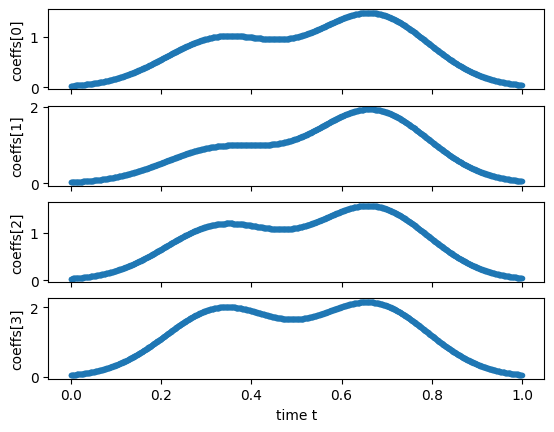

In [5]:
ts = jnp.linspace(0.0, 1, 1000)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()


In [6]:

from datetime import datetime

n_epochs = 100
param_vector = perceptron.get_random_parameter_vector(0)

# The following block creates a constant schedule of the learning rate
# that increases from 0.1 to 0.5 after 10 epochs
# schedule0 = optax.constant_schedule(1e-1)
# schedule1 = optax.constant_schedule(5e-1)
# schedule = optax.join_schedules([schedule0, schedule1], [20])
# optimizer = optax.adam(learning_rate=schedule)
optimizer = optax.adam(learning_rate=1)
opt_state = optimizer.init(param_vector)

energy = np.zeros(n_epochs + 1)
energy[0] = loss(param_vector)
mean_gradients = np.zeros(n_epochs)
param_trajectory = []

## Compile the evaluation and gradient function and report compilation time
time0 = datetime.now()
_ = value_and_grad(param_vector)
time1 = datetime.now()
print(f"grad and val compilation time: {time1 - time0}")


## Optimization loop
for n in range(n_epochs):
    val, grads = value_and_grad(param_vector)
    updates, opt_state = optimizer.update(grads, opt_state)
    param_vector = optax.apply_updates(param_vector, updates)

    mean_gradients[n] = np.mean(np.abs(grads))
    energy[n+1] = val

    # print(f"            param: {param_vector}")

    if not n % 10:
        print(f"{n+1} / {n_epochs}; energy discrepancy: {val-e_ground_state_exact}")
        print(f"mean grad: {mean_gradients[n]}")



print(f"Found ground state: {energy[-1]}")


grad and val compilation time: 0:00:05.597017
1 / 100; energy discrepancy: 3.6980590932886805
mean grad: 0.46503179003745837
11 / 100; energy discrepancy: 2.9314723516203616
mean grad: 0.4786503837524929
21 / 100; energy discrepancy: 0.9555390624524969
mean grad: 0.3853365426449567
31 / 100; energy discrepancy: 0.5269510963065276
mean grad: 0.3226372842146949
41 / 100; energy discrepancy: 0.11144231075953259
mean grad: 0.12286323707532387
51 / 100; energy discrepancy: 0.0574918996651288
mean grad: 0.13666454238088863
61 / 100; energy discrepancy: 0.02367157070947723
mean grad: 0.07147899615472528
71 / 100; energy discrepancy: 0.012414200173503254
mean grad: 0.04913737146510425
81 / 100; energy discrepancy: 0.005062545033791999
mean grad: 0.01184417552306958
91 / 100; energy discrepancy: 0.00434015149618272
mean grad: 0.02314845461595364
Found ground state: -2.983927843474958


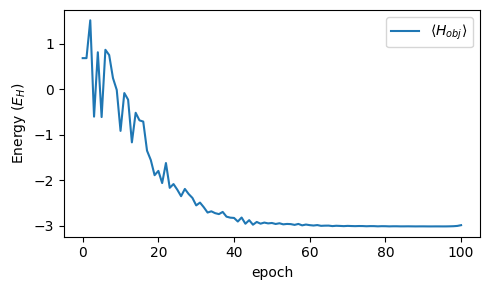

In [7]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = energy 
ax.plot(y, label="$\\langle H_{{obj}}\\rangle$")
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle$")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

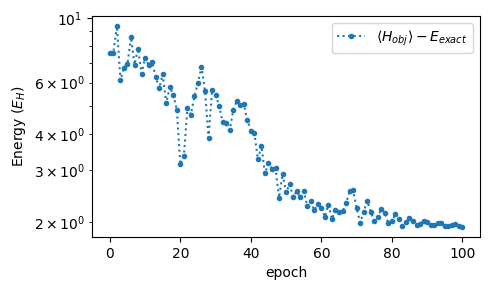

In [8]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

y = energy - e_ground_state_exact
ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Energy ($E_H$)")
ax.set_xlabel("epoch")
ax.legend()

plt.tight_layout()
plt.show()

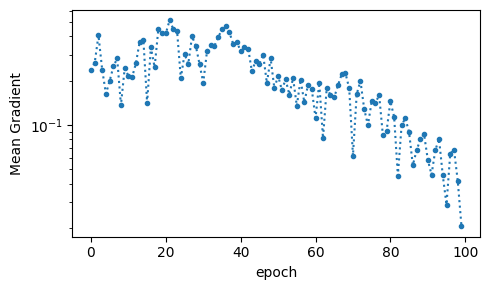

In [9]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = mean_gradients
# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
ax.set_yscale("log")
ax.set_ylabel("Mean Gradient")
ax.set_xlabel("epoch")
# ax.legend()

plt.tight_layout()
plt.show()

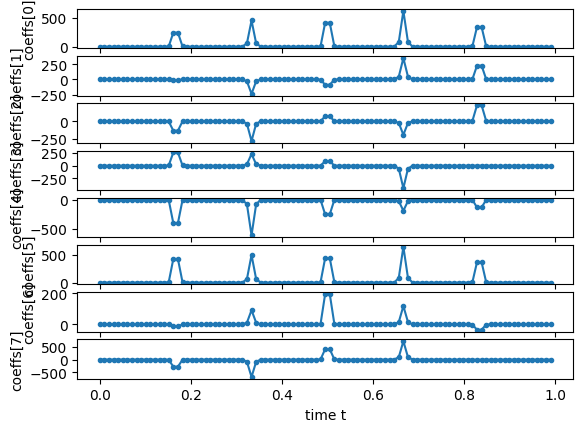

In [10]:
ts = jnp.linspace(0.0, 1, 100)[:-1]

param_list = perceptron.vector_to_hamiltonian_parameters(param_vector)

fig, axs = plt.subplots(nrows=perceptron_qubits, sharex=True)
for i in range(perceptron_qubits):
    ax = axs[i]
    ax.plot(ts, perceptron.control_fields[i](param_list[i+perceptron_qubits-1], ts), ".-")
    ax.set_ylabel(f"coeffs[{i}]")
ax.set_xlabel("time t")
plt.show()

In [23]:
# Calculating the Final Hessian

final_hessian = jax.jacrev(jax.jacrev(loss))(param_vector)
final_hessian_eigenvalues = jnp.linalg.eigvals(final_hessian)
final_hessian_eigenvalues

KeyboardInterrupt: 

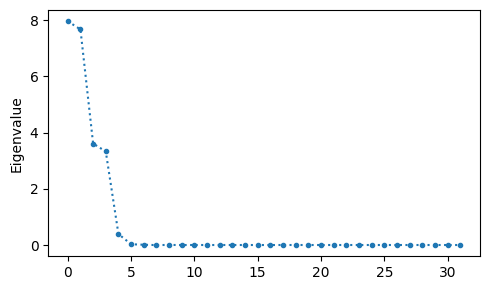

In [ ]:
fig, ax = plt.subplots(nrows=1, figsize=(5, 3), sharex=True)

# y = np.array(energy) - e_ground_state_exact
y = np.linalg.eigvals(final_hessian)

# ax.plot(y, ".:", label="$\\langle H_{{obj}}\\rangle - E_{exact}$")
ax.plot(y, ".:")
# ax.fill_between([0, len(y)], [1e-3] * 2, 3e-4, alpha=0.2, label="chem acc.")
# ax.set_yscale("log")
ax.set_ylabel("Eigenvalue")
# ax.set_xlabel("Eigenvalue")
# ax.legend()

plt.tight_layout()
plt.show()